## Figures 1-2: Probability snapshots

This notebook reproduces Figures 1-2, using similar code to `03-create_probability_animation.ipynb`.

In [1]:
use_extracted_data = False

In [2]:
import glob
import os
from string import ascii_uppercase

import cartopy.crs as ccrs
import gplately
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lib.check_files import (
    check_plate_model,
    check_prepared_data,
)

In [3]:
output_dir = os.path.join("figures")
os.makedirs(output_dir, exist_ok=True)

### Load plate model files

In [4]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir, verbose=True)
model_dir = "plate_model"
check_plate_model(model_dir)
input_dir = os.path.join("outputs", "grids")

data_filename = os.path.join(data_dir, "training_data.csv")

feature_filenames = glob.glob(
    os.path.join(
        model_dir,
        "*.gpml",
    )
) + glob.glob(
    os.path.join(
        model_dir,
        "*.gpmlz",
    )
)
rotation_filenames = glob.glob(
    os.path.join(
        model_dir,
        "*.rot",
    )
)
coastlines_filename = os.path.join(
    model_dir,
    "StaticGeometries",
    "AgeGridInput",
    "CombinedTerranes.gpml",
)

model = gplately.PlateReconstruction(
    rotation_model=rotation_filenames,
    topology_features=feature_filenames,
)
gplot = gplately.PlotTopologies(
    model,
    coastlines=coastlines_filename,
)

### Load positive training data points

In [5]:
df = pd.read_csv(data_filename)
positives = df[df["label"] == "positive"]

### Plot probability snapshots

In [6]:
times_0 = (160, 140, 120, 100)
times_1 = (75, 50, 25, 0)

In [7]:
font_size = 18
tick_size = font_size * 0.8
title_size = font_size * 1.25

figsize = (7.125, 9.5)  # GSA Bulletin max page size

subplot_kw = {
    "projection": ccrs.Orthographic(-100, 10),
    "facecolor": "0.975",
}
gridspec_kw = {
    "wspace": 0.08,
    "hspace": 0.12,
    "bottom": 0.2,
    "top": 0.9,
    "left": 0.01,
    "right": 0.99,
}

cmap = "plasma_r"

markerfacecolor = "white"

boundary_linewidth = 0.75

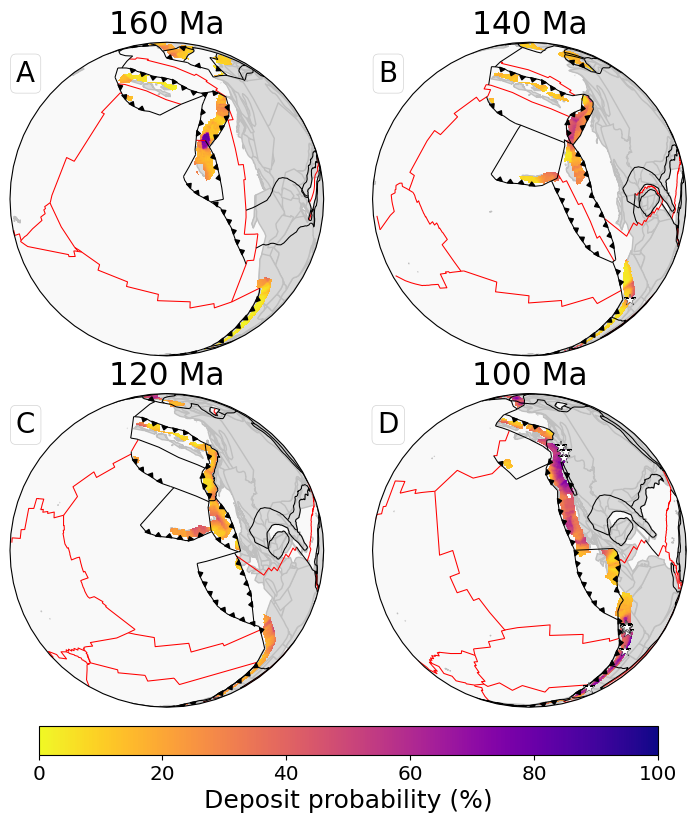

In [8]:
output_basename = os.path.join(output_dir, "Fig-01-probability_snapshots_0")
fig, axs = plt.subplots(
    2, 2,
    figsize=figsize,
    subplot_kw=subplot_kw,
    gridspec_kw=gridspec_kw,
)
left = axs[0, 0].get_position().x0 + 0.04
width = axs[0, 1].get_position().x1 - 0.04 - left
cax = fig.add_axes(
    [
        left,
        gridspec_kw["bottom"] - 0.05,
        width,
        0.03,
    ]
)

for time, ax, label in zip(
    times_0,
    np.ravel(axs),
    ascii_uppercase,
):
    ax.set_title("{} Ma".format(time), fontsize=title_size)
    input_filename = os.path.join(
        input_dir,
        "probability_grid_{}Ma.nc".format(time),
    )
    raster = gplately.Raster(
        plate_reconstruction=model,
        data=input_filename,
        time=time,
    )
    raster.data *= 100.0
    im = raster.imshow(
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=100,
        zorder=1,
    )
    gplot.time = time
    gplot.plot_coastlines(
        ax=ax,
        facecolor="0.85",
        edgecolor="0.75",
        zorder=0,
    )
    gplot.plot_ridges_and_transforms(
        ax=ax,
        color="red",
        linewidth=boundary_linewidth,
        zorder=2,
    )
    gplot.plot_misc_boundaries(
        ax=ax,
        color="black",
        linewidth=boundary_linewidth,
        zorder=2,
    )
    gplot.plot_trenches(
        ax=ax,
        color="black",
        linewidth=boundary_linewidth,
        zorder=2,
    )
    gplot.plot_subduction_teeth(
        ax=ax,
        color="black",
        zorder=3,
    )

    df_time = positives[
        np.abs(positives["age (Ma)"] - time) <= 5.0
    ]
    ax.plot(
        df_time["lon"],
        df_time["lat"],
        linestyle="none",
        marker="*",
        markeredgecolor="black",
        markeredgewidth=0.25,
        markerfacecolor=markerfacecolor,
        markersize=9.0,
        transform=ccrs.PlateCarree(),
        zorder=20,
    )
    ax.set_global()
    ax.text(
        0.05, 0.9,
        label,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=20,
        bbox=dict(
            facecolor="white",
            edgecolor="lightgrey",
            linewidth=0.5,
            boxstyle="Round, pad=0.2, rounding_size=0.2",
        )
    )

cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.ax.set_xlabel("Deposit probability (%)", fontsize=font_size)
cbar.ax.tick_params(labelsize=tick_size)

for extension in (".pdf", ".png"):
    fig.savefig(
        output_basename + extension,
        dpi=350,
        bbox_inches="tight",
    )

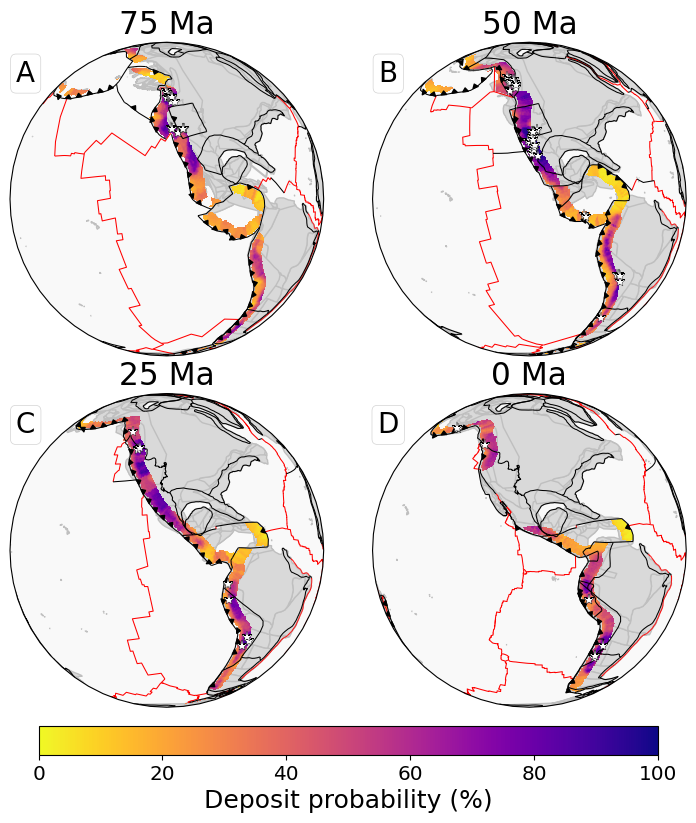

In [9]:
output_basename = os.path.join(output_dir, "Fig-02-probability_snapshots_1")

fig, axs = plt.subplots(
    2, 2,
    figsize=figsize,
    subplot_kw=subplot_kw,
    gridspec_kw=gridspec_kw,
)
left = axs[0, 0].get_position().x0 + 0.04
width = axs[0, 1].get_position().x1 - 0.04 - left
cax = fig.add_axes(
    [
        left,
        gridspec_kw["bottom"] - 0.05,
        width,
        0.03,
    ]
)

for time, ax, label in zip(
    times_1,
    np.ravel(axs),
    ascii_uppercase,
):
    ax.set_title("{} Ma".format(time), fontsize=title_size)
    input_filename = os.path.join(
        input_dir,
        "probability_grid_{}Ma.nc".format(time),
    )
    raster = gplately.Raster(
        plate_reconstruction=model,
        data=input_filename,
        time=time,
    )
    raster.data *= 100.0
    im = raster.imshow(
        ax=ax,
        cmap=cmap,
        vmin=0,
        vmax=100,
        zorder=1,
    )
    gplot.time = time
    gplot.plot_coastlines(
        ax=ax,
        facecolor="0.85",
        edgecolor="0.75",
        zorder=0,
    )
    gplot.plot_ridges_and_transforms(
        ax=ax,
        color="red",
        linewidth=boundary_linewidth,
        zorder=2,
    )
    gplot.plot_misc_boundaries(
        ax=ax,
        color="black",
        linewidth=boundary_linewidth,
        zorder=2,
    )
    gplot.plot_trenches(
        ax=ax,
        color="black",
        linewidth=boundary_linewidth,
        zorder=2,
    )
    gplot.plot_subduction_teeth(
        ax=ax,
        color="black",
        zorder=3,
    )

    df_time = positives[
        np.abs(positives["age (Ma)"] - time) <= 5.0
    ]
    ax.plot(
        df_time["lon"],
        df_time["lat"],
        linestyle="none",
        marker="*",
        markeredgecolor="black",
        markeredgewidth=0.25,
        markerfacecolor=markerfacecolor,
        markersize=8.0,
        transform=ccrs.PlateCarree(),
        zorder=20,
    )
    ax.set_global()
    ax.text(
        0.05, 0.9,
        label,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
        fontsize=20,
        bbox=dict(
            facecolor="white",
            edgecolor="lightgrey",
            linewidth=0.5,
            boxstyle="Round, pad=0.2, rounding_size=0.2",
        )
    )

cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.ax.set_xlabel("Deposit probability (%)", fontsize=font_size)
cbar.ax.tick_params(labelsize=tick_size)

for extension in (".pdf", ".png"):
    fig.savefig(
        output_basename + extension,
        dpi=350,
        bbox_inches="tight",
    )